# MA opioid overdose death, ACS, and Medicare part D data merge

### Goals:
* Resolve NPI prescribers being assigned to more than one town (zip code matched to more than one town most likely)
* Fill in missing opioid prescription rates
* associate towns (opioid overdose death rates + acs) and medicare drug spending/claim counts
* EDA on potential relationship between opioid overdose deaths and opioid or benzo claims

### Outputs:
* `data/tidy_data/medicare_partD_opioid_prescriber_all_years_no_ziptown_duplicates.csv` - concatenated (rows) of opioid prescribers, with zip codes assigned to only one town (using random removal)
* `data/tidy_data/overdose_death_count_acs_merge_long_format.csv` - reformatted overdose death count and ACS merged data from wide format to long format (death counts and total population columns)
* `data/tidy_data/acs_medicare_opioid_stats_death_count_merge.csv` - opioid overdose death counts, ACS data, and opioid prescription patterns summarized and merged
* pdf report (in case notebook won't run): `products/notebook_6_ma_opioid_overdose_death_and_acs_and_partD_drug_match_by_town.pdf`

In [1]:
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set(font_scale=1.5)

In [2]:
death_and_acs_data = pd.read_csv("../../../data/tidy_data/overdose_death_count_acs_merge.csv")
opi_pres_13 = pd.read_csv("../../../data/tidy_data/medicare_partD_opioid_prescriber_2013_w_zip_MAtown_v1.csv")
opi_pres_14 = pd.read_csv("../../../data/tidy_data/medicare_partD_opioid_prescriber_2014_w_zip_MAtown_v1.csv")
opi_pres_15 = pd.read_csv("../../../data/tidy_data/medicare_partD_opioid_prescriber_2015_w_zip_MAtown_v1.csv")
opi_pres_16 = pd.read_csv("../../../data/tidy_data/medicare_partD_opioid_prescriber_2016_w_zip_MAtown_v1.csv")
opi_pres_17 = pd.read_csv("../../../data/tidy_data/medicare_partD_opioid_prescriber_2017_w_zip_MAtown_v1.csv")

In [3]:
opi_pres_13.head()

,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,town,nppes_provider_state,specialty_description,total_claim_count,opioid_claim_count,opioid_prescribing_rate,long-acting_opioid_claim_count,year
0,1003002312,hopkins,patricia,2169,quincy,MA,internal medicine,4139,522.0,12.61,104.0,2013
1,1003083270,kabadi,mitesh,2169,quincy,MA,cardiology,40,0.0,0.00,0.0,2013
2,1003834433,nair,anil,2169,quincy,MA,neurology,1217,NaN,NaN,NaN,2013
3,1003895269,angelini,domenic,2169,quincy,MA,dentist,14,0.0,0.00,0.0,2013
4,1003992397,carolan,patricia,2169,quincy,MA,dentist,37,NaN,NaN,0.0,2013


In [4]:
opi_pres_df = [opi_pres_13, opi_pres_14, opi_pres_15, opi_pres_16, opi_pres_17]

In [5]:
for x in opi_pres_df:
    print(x['nppes_provider_state'].value_counts())
for x in opi_pres_df:
    x.drop('nppes_provider_state', axis=1, inplace=True)

MA    34086
Name: nppes_provider_state, dtype: int64
MA    34734
Name: nppes_provider_state, dtype: int64
MA    35416
Name: nppes_provider_state, dtype: int64
MA    36357
Name: nppes_provider_state, dtype: int64
MA    37069
Name: nppes_provider_state, dtype: int64


In [6]:
opi_pres_13.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34086 entries, 0 to 34085
Data columns (total 11 columns):
npi                               34086 non-null int64
nppes_provider_last_name          34085 non-null object
nppes_provider_first_name         34002 non-null object
nppes_provider_zip_code           34086 non-null int64
town                              34086 non-null object
specialty_description             34086 non-null object
total_claim_count                 34086 non-null int64
opioid_claim_count                22667 non-null float64
opioid_prescribing_rate           22667 non-null float64
long-acting_opioid_claim_count    28188 non-null float64
year                              34086 non-null int64
dtypes: float64(3), int64(4), object(4)
memory usage: 2.9+ MB


In [7]:
# fix the zip codes again - some kind of issue related to importing it
for x in opi_pres_df:
    x['nppes_provider_zip_code'] = x['nppes_provider_zip_code'].astype(str).str.zfill(5)

In [8]:
opi_pres_13.head()

,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,town,specialty_description,total_claim_count,opioid_claim_count,opioid_prescribing_rate,long-acting_opioid_claim_count,year
0,1003002312,hopkins,patricia,02169,quincy,internal medicine,4139,522.0,12.61,104.0,2013
1,1003083270,kabadi,mitesh,02169,quincy,cardiology,40,0.0,0.00,0.0,2013
2,1003834433,nair,anil,02169,quincy,neurology,1217,NaN,NaN,NaN,2013
3,1003895269,angelini,domenic,02169,quincy,dentist,14,0.0,0.00,0.0,2013
4,1003992397,carolan,patricia,02169,quincy,dentist,37,NaN,NaN,0.0,2013


In [9]:
# concatinate all rows for all years together
opi_pres_all = pd.concat(opi_pres_df, axis=0, ignore_index=True)

In [10]:
for x in opi_pres_df:
    print(x.shape)
print(opi_pres_all.shape)

(34086, 11)
(34734, 11)
(35416, 11)
(36357, 11)
(37069, 11)
(177662, 11)


In [11]:
# according to documentation, opioid claims are redacted if claim count is between 1-10 (not zero - reveals if 0) 
# replace missing claim with 5
opi_pres_all['opioid_claim_count'] = opi_pres_all['opioid_claim_count'].fillna(value=5.0)
# calculate rate with replaced values
opi_pres_all['calc_opioid_rate'] = (opi_pres_all['opioid_claim_count'] / opi_pres_all['total_claim_count']) * 100
opi_pres_all.head()

,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,town,specialty_description,total_claim_count,opioid_claim_count,opioid_prescribing_rate,long-acting_opioid_claim_count,year,calc_opioid_rate
0,1003002312,hopkins,patricia,02169,quincy,internal medicine,4139,522.0,12.61,104.0,2013,12.611742
1,1003083270,kabadi,mitesh,02169,quincy,cardiology,40,0.0,0.00,0.0,2013,0.000000
2,1003834433,nair,anil,02169,quincy,neurology,1217,5.0,NaN,NaN,2013,0.410846
3,1003895269,angelini,domenic,02169,quincy,dentist,14,0.0,0.00,0.0,2013,0.000000
4,1003992397,carolan,patricia,02169,quincy,dentist,37,5.0,NaN,0.0,2013,13.513514


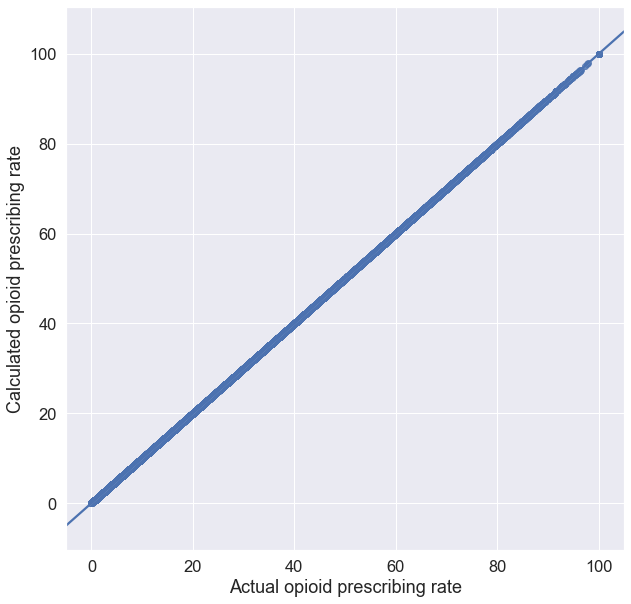

In [12]:
# was the opioid prescribing rate calculated as I expected?
# compare calculated rate with actual rate where it is not missing
plt.figure(figsize=(10,10))
sns.regplot(x='opioid_prescribing_rate', y='calc_opioid_rate', data=opi_pres_all.dropna())
plt.xlabel('Actual opioid prescribing rate')
plt.ylabel('Calculated opioid prescribing rate')
plt.show()
# A: yes

Now for the prescribers that were associated with more than 1 town per year:

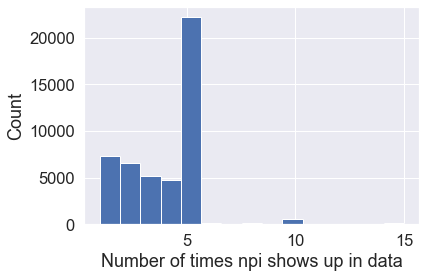

In [13]:
npi_counts = opi_pres_all['npi'].value_counts().reset_index()
npi_counts['npi'].hist(bins=15)
plt.xlabel('Number of times npi shows up in data')
plt.ylabel('Count')
plt.show()

In [14]:
npi_counts.head()

,index,npi
0,1801868161,15
1,1417060989,15
2,1265650162,15
3,1205096583,15
4,1760446140,15


In [15]:
# where is the problem coming from?
opi_pres_all[opi_pres_all['npi'] == npi_counts.iloc[0,0]].sort_values('year')

,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,town,specialty_description,total_claim_count,opioid_claim_count,opioid_prescribing_rate,long-acting_opioid_claim_count,year,calc_opioid_rate
20515,1801868161,costa,joseph,02467,brookline,dentist,18,5.0,NaN,0.0,2013,27.777778
20516,1801868161,costa,joseph,02467,boston,dentist,18,5.0,NaN,0.0,2013,27.777778
20517,1801868161,costa,joseph,02467,newton,dentist,18,5.0,NaN,0.0,2013,27.777778
55159,1801868161,costa,joseph,02467,brookline,dentist,25,5.0,NaN,0.0,2014,20.000000
55160,1801868161,costa,joseph,02467,boston,dentist,25,5.0,NaN,0.0,2014,20.000000
55161,1801868161,costa,joseph,02467,newton,dentist,25,5.0,NaN,0.0,2014,20.000000
90560,1801868161,costa,joseph,02467,brookline,dentist,22,5.0,NaN,0.0,2015,22.727273
90561,1801868161,costa,joseph,02467,boston,dentist,22,5.0,NaN,0.0,2015,22.727273
90562,1801868161,costa,joseph,02467,newton,dentist,22,5.0,NaN,0.0,2015,22.727273
128212,1801868161,costa,joseph,02467,brookline,dentist,14,0.0,0.0,0.0,2016,0.000000


Same zip code is being associated with multiple towns per year - the same prescriber appears in triplicate for each year with the same prescription numbers.

Try to understand the problem a little bit more.

What if some prescribers are not in all 5 datasets, but their zip code is associated with more than 1 town for the years that they do appear - number of npi appearances might be less than 5, but their information appears 2x/3x?

In [16]:
npi_counts[npi_counts['npi'] > 5]

,index,npi
0,1801868161,15
1,1417060989,15
2,1265650162,15
3,1205096583,15
4,1760446140,15
...,...,...
1197,1033269782,6
1198,1205277761,6
1199,1609250406,6
1200,1154736007,6


In [17]:
opi_pres_all[opi_pres_all['npi'] == 1790044303]

,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,town,specialty_description,total_claim_count,opioid_claim_count,opioid_prescribing_rate,long-acting_opioid_claim_count,year,calc_opioid_rate
24564,1790044303,agnoli,alicia,02148,malden,student in an organized health care education/...,87,5.0,NaN,NaN,2013,5.747126
24565,1790044303,agnoli,alicia,02148,revere,student in an organized health care education/...,87,5.0,NaN,NaN,2013,5.747126
59258,1790044303,agnoli,alicia,02148,malden,student in an organized health care education/...,369,29.0,7.86,NaN,2014,7.859079
59259,1790044303,agnoli,alicia,02148,revere,student in an organized health care education/...,369,29.0,7.86,NaN,2014,7.859079
94296,1790044303,agnoli,alicia,02148,malden,student in an organized health care education/...,470,25.0,5.32,NaN,2015,5.319149
94297,1790044303,agnoli,alicia,02148,revere,student in an organized health care education/...,470,25.0,5.32,NaN,2015,5.319149


Working through these would take too long, but duplicates per year should be removed. Luckily this is a problem for a relatively small number out of the total prescribers. Will resolve this by randomly dropping duplicates per year.

In [18]:
len(opi_pres_all.index)

177662

In [19]:
# generate random index order
l = random.sample(range(0,177662), 177662)

In [20]:
opi_pres_all['sort_index'] = l
opi_pres_all.head()

,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,town,specialty_description,total_claim_count,opioid_claim_count,opioid_prescribing_rate,long-acting_opioid_claim_count,year,calc_opioid_rate,sort_index
0,1003002312,hopkins,patricia,02169,quincy,internal medicine,4139,522.0,12.61,104.0,2013,12.611742,172909
1,1003083270,kabadi,mitesh,02169,quincy,cardiology,40,0.0,0.00,0.0,2013,0.000000,59056
2,1003834433,nair,anil,02169,quincy,neurology,1217,5.0,NaN,NaN,2013,0.410846,29246
3,1003895269,angelini,domenic,02169,quincy,dentist,14,0.0,0.00,0.0,2013,0.000000,111291
4,1003992397,carolan,patricia,02169,quincy,dentist,37,5.0,NaN,0.0,2013,13.513514,107657


In [21]:
print(len(opi_pres_all[['npi', 'nppes_provider_last_name', 'nppes_provider_first_name']].drop_duplicates().index))
print(len(opi_pres_all[['npi']].drop_duplicates().index))
print(len(opi_pres_all[['npi', 'year']].drop_duplicates().index))
print(len(opi_pres_all[['npi', 'year', 'nppes_provider_last_name', 'nppes_provider_first_name']].drop_duplicates().index))

47875
47160
170744
170744


Not sure what's going on with the npi/name combos

In [22]:
opi_pres_no_zip_dup = opi_pres_all.sort_values(['npi', 'year', 'sort_index']).drop_duplicates(subset=['npi', 'year', 'nppes_provider_last_name', 'nppes_provider_first_name'], keep='last')
print(opi_pres_no_zip_dup.shape)

(170744, 13)


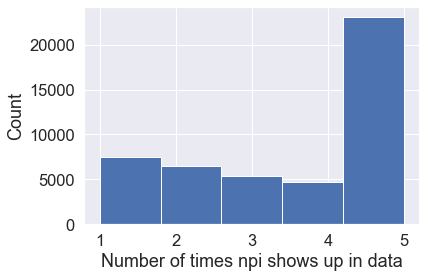

In [23]:
npi_counts_updt = opi_pres_no_zip_dup['npi'].value_counts().reset_index()
npi_counts_updt['npi'].hist(bins=5)
plt.xlabel('Number of times npi shows up in data')
plt.ylabel('Count')
plt.show()

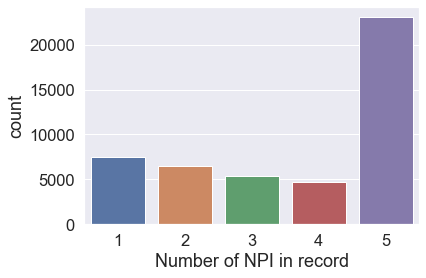

In [24]:
sns.countplot(x="npi", data=npi_counts_updt)
plt.xlabel('Number of NPI in record')
plt.show()

Although not the best solution, the problem is resolved quickly at least.

Prepare for export:

In [25]:
opi_pres_no_zip_dup.columns

Index(['npi', 'nppes_provider_last_name', 'nppes_provider_first_name',
       'nppes_provider_zip_code', 'town', 'specialty_description',
       'total_claim_count', 'opioid_claim_count', 'opioid_prescribing_rate',
       'long-acting_opioid_claim_count', 'year', 'calc_opioid_rate',
       'sort_index'],
      dtype='object')

In [26]:
opi_pres_no_zip_dup.drop(['long-acting_opioid_claim_count', 'opioid_prescribing_rate', 'sort_index'], axis=1, inplace=True)
opi_pres_no_zip_dup.head()

,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,town,specialty_description,total_claim_count,opioid_claim_count,year,calc_opioid_rate
34086,1003001660,newton,robert,02446,brookline,urology,12,0.0,2014,0.000000
0,1003002312,hopkins,patricia,02169,quincy,internal medicine,4139,522.0,2013,12.611742
34365,1003002312,hopkins,patricia,02169,quincy,internal medicine,4467,542.0,2014,12.133423
68820,1003002312,hopkins,patricia,02169,quincy,internal medicine,4183,495.0,2015,11.833612
104236,1003002312,hopkins,patricia,02169,quincy,rheumatology,4634,593.0,2016,12.796720


In [27]:
# to keep zeroes in zipcode when writing
opi_pres_no_zip_dup['nppes_provider_zip_code'] = opi_pres_no_zip_dup['nppes_provider_zip_code'].astype('str')

In [28]:
print(death_and_acs_data.shape)
death_and_acs_data.head()

(347, 20)


,city_death,2014,2015,2016,2017,2018,tot_pop_13,tot_pop_14,tot_pop_15,tot_pop_16,tot_pop_17,over_65_count,over_65_prop,med_house_inc,mean_house_inc,less_than_hs_ed,at_or_below_pov_prop,pop_struggling_prop,urb_v_rur,town_status
0,abington,0,6,1,3,5,16109.285714,16150.714286,16192.142857,16233.571429,16275,2469,0.151705,87156.000000,98809.035505,5.405643,0.035754,0.100408,rural,grown
1,acton,1,2,3,0,1,22580.142857,22798.857143,23017.571429,23236.285714,23455,4001,0.170582,139890.466667,156680.203867,2.456531,0.038315,0.041747,rural,grown
2,acushnet,0,4,2,4,0,10363.000000,10383.000000,10403.000000,10423.000000,10443,2431,0.232788,69624.714286,80333.175842,18.297315,0.040828,0.178406,rural,grown
3,adams,2,3,1,0,4,8367.571429,8328.428571,8289.285714,8250.142857,8211,1764,0.214834,48445.400000,60968.594660,11.862182,0.110854,0.144597,rural,shrunk
4,agawam,1,2,0,4,8,27684.428571,27705.571429,27726.714286,27747.857143,27769,6195,0.223090,65490.125000,79464.234446,7.748863,0.094819,0.142656,rural,grown


Towns missing from one dataset or another:

In [29]:
print(len(set(death_and_acs_data['city_death']) - set(opi_pres_no_zip_dup['town'])))
print(len(set(opi_pres_no_zip_dup['town']) - set(death_and_acs_data['city_death'])))

54
3


In [30]:
set(opi_pres_no_zip_dup['town']) - set(death_and_acs_data['city_death'])

{'manchester by the sea', 'monroe', 'worthington'}

In [31]:
set(death_and_acs_data['city_death']) - set(opi_pres_no_zip_dup['town'])

{'acushnet',
 'alford',
 'aquinnah',
 'ashby',
 'becket',
 'blandford',
 'cheshire',
 'chesterfield',
 'clarksburg',
 'colrain',
 'cummington',
 'dunstable',
 'east brookfield',
 'erving',
 'florida',
 'gill',
 'gosnold',
 'granby',
 'granville',
 'hancock',
 'hawley',
 'heath',
 'hinsdale',
 'holland',
 'leyden',
 'manchester',
 'middlefield',
 'millville',
 'montgomery',
 'mount washington',
 'nahant',
 'new ashford',
 'new braintree',
 'new marlborough',
 'new salem',
 'northfield',
 'oakham',
 'pelham',
 'peru',
 'petersham',
 'phillipston',
 'plympton',
 'rowe',
 'royalston',
 'russell',
 'sandisfield',
 'savoy',
 'tolland',
 'tyringham',
 'wales',
 'warwick',
 'washington',
 'wendell',
 'westhampton'}

In [32]:
opi_pres_no_zip_dup['town'] = opi_pres_no_zip_dup['town'].str.replace('manchester by the sea', 'manchester')

In [33]:
set(opi_pres_no_zip_dup['town']) - set(death_and_acs_data['city_death'])

{'monroe', 'worthington'}

In [34]:
opi_pres_no_zip_dup.head()

,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,town,specialty_description,total_claim_count,opioid_claim_count,year,calc_opioid_rate
34086,1003001660,newton,robert,02446,brookline,urology,12,0.0,2014,0.000000
0,1003002312,hopkins,patricia,02169,quincy,internal medicine,4139,522.0,2013,12.611742
34365,1003002312,hopkins,patricia,02169,quincy,internal medicine,4467,542.0,2014,12.133423
68820,1003002312,hopkins,patricia,02169,quincy,internal medicine,4183,495.0,2015,11.833612
104236,1003002312,hopkins,patricia,02169,quincy,rheumatology,4634,593.0,2016,12.796720


### File disclaimer:

Generating the `l` index is random - forgot to set seed - when rerunning the notebook the output will probably change. I'm going to use the file that I created when this notebook was first run. There may be minor differences in prescriber assignment to town if the notebook is run again.

In [35]:
#opi_pres_no_zip_dup.to_csv("../../../data/tidy_data/medicare_partD_opioid_prescriber_all_years_no_ziptown_duplicates.csv", index=False)

### Now to merge the opioid overdose deaths and the opioid prescription data together:

In [3]:
opi_pres_no_zip_dup = pd.read_csv("../../../data/tidy_data/medicare_partD_opioid_prescriber_all_years_no_ziptown_duplicates.csv")

In [4]:
opi_pres_no_zip_dup.head()
opi_pres_no_zip_dup.drop('nppes_provider_zip_code', axis=1, inplace=True)

In [5]:
# summarize the prescription data by town and year (average of rates)
opi_pres_mean_stats = opi_pres_no_zip_dup.groupby(['town', 'year']).mean().reset_index().drop('npi', axis=1)
opi_pres_mean_stats.columns = ['town', 'year', 'total_claims_count_avg', 'opioid_claim_count_avg', 'opioid_rate_avg']
opi_pres_mean_stats.head()

,town,year,total_claims_count_avg,opioid_claim_count_avg,opioid_rate_avg
0,abington,2013,2179.083333,89.666667,7.123603
1,abington,2014,1925.350000,79.700000,7.807532
2,abington,2015,2408.916667,64.041667,6.627004
3,abington,2016,2871.857143,72.333333,4.429928
4,abington,2017,2498.826087,67.434783,5.274131


In [6]:
# summarize the prescription data by town and year (sum of counts)
opi_pres_sum_stats = opi_pres_no_zip_dup.groupby(['town', 'year']).sum().reset_index().drop(['npi', 'calc_opioid_rate'], axis=1)
opi_pres_sum_stats.columns = ['town', 'year', 'total_claim_count_sum', 'opioid_claim_count_sum']
opi_pres_sum_stats.head()

,town,year,total_claim_count_sum,opioid_claim_count_sum
0,abington,2013,52298,2152.0
1,abington,2014,38507,1594.0
2,abington,2015,57814,1537.0
3,abington,2016,60309,1519.0
4,abington,2017,57473,1551.0


In [7]:
print(opi_pres_mean_stats.shape)
print(opi_pres_sum_stats.shape)
opi_pres_stats = opi_pres_mean_stats.merge(opi_pres_sum_stats, on=['town', 'year'], how='inner')
print(opi_pres_stats.shape)
display(opi_pres_stats.head())
display(opi_pres_stats.describe())

(1438, 5)
(1438, 4)
(1438, 7)


,town,year,total_claims_count_avg,opioid_claim_count_avg,opioid_rate_avg,total_claim_count_sum,opioid_claim_count_sum
0,abington,2013,2179.083333,89.666667,7.123603,52298,2152.0
1,abington,2014,1925.350000,79.700000,7.807532,38507,1594.0
2,abington,2015,2408.916667,64.041667,6.627004,57814,1537.0
3,abington,2016,2871.857143,72.333333,4.429928,60309,1519.0
4,abington,2017,2498.826087,67.434783,5.274131,57473,1551.0


,year,total_claims_count_avg,opioid_claim_count_avg,opioid_rate_avg,total_claim_count_sum,opioid_claim_count_sum
count,1438.000000,1438.000000,1438.000000,1438.000000,1.438000e+03,1438.000000
mean,2014.995132,1368.366165,61.048364,8.856701,1.122620e+05,4723.317803
std,1.413467,1031.772994,56.621581,6.175832,3.413563e+05,14546.384508
min,2013.000000,11.000000,0.000000,0.000000,1.100000e+01,0.000000
25%,2014.000000,790.629670,27.251136,5.325307,1.087675e+04,420.250000
50%,2015.000000,1226.000000,48.902206,8.091398,3.376600e+04,1396.500000
75%,2016.000000,1707.300826,76.386719,11.058857,9.881100e+04,4184.000000
max,2017.000000,8922.636364,555.500000,69.696970,5.442227e+06,209604.000000


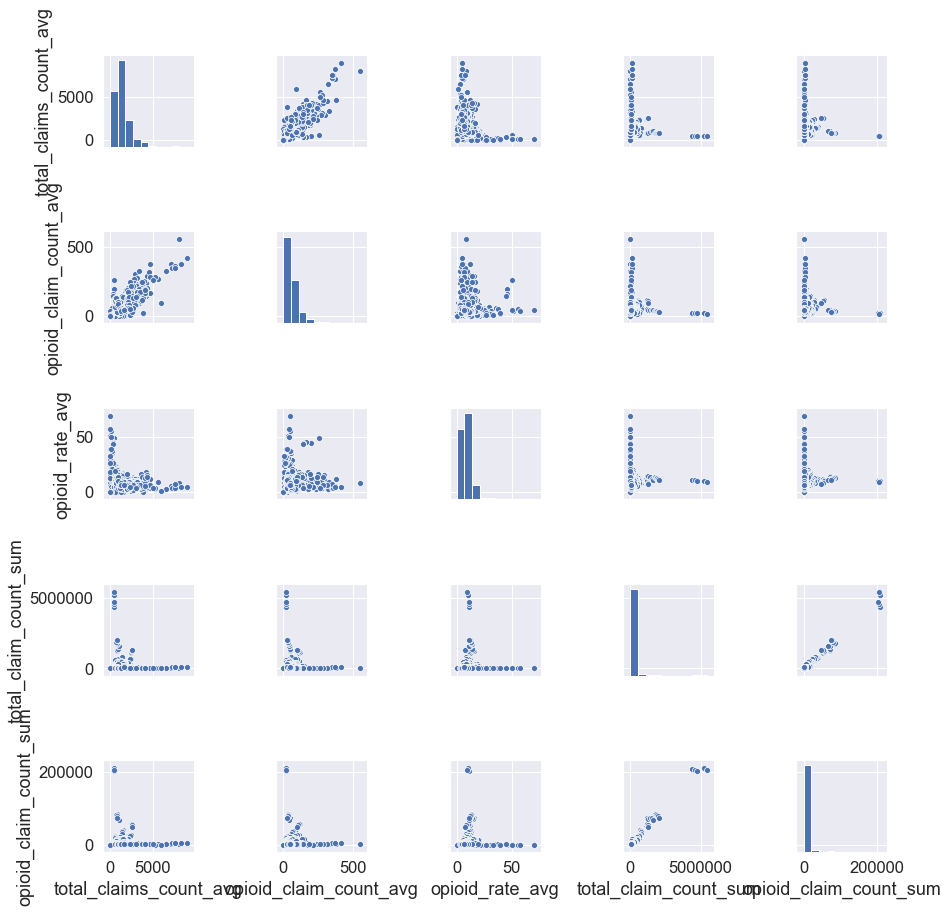

In [8]:
sns.pairplot(opi_pres_stats.drop(['town', 'year'], axis=1))

Claim count features are very skewed - not surprising, probably depends on population:

In [9]:
# where were the highest claims?
opi_pres_stats[opi_pres_stats['total_claim_count_sum'] > 2000000]

,town,year,total_claims_count_avg,opioid_claim_count_avg,opioid_rate_avg,total_claim_count_sum,opioid_claim_count_sum
144,boston,2013,436.120317,20.636274,11.472438,4400454,208220.0
145,boston,2014,447.212293,20.033951,11.057803,4583926,205348.0
146,boston,2015,453.524232,19.308529,10.666161,4753841,202392.0
147,boston,2016,474.821885,19.145415,10.180812,5198350,209604.0
148,boston,2017,479.280229,18.064465,9.217205,5442227,205122.0
1422,worcester,2017,806.286672,29.255915,10.768587,2044743,74193.0


In [10]:
death_and_acs_data

,city_death,2014,2015,2016,2017,2018,tot_pop_13,tot_pop_14,tot_pop_15,tot_pop_16,tot_pop_17,over_65_count,over_65_prop,med_house_inc,mean_house_inc,less_than_hs_ed,at_or_below_pov_prop,pop_struggling_prop,urb_v_rur,town_status
0,abington,0,6,1,3,5,16109.285714,16150.714286,16192.142857,16233.571429,16275,2469,0.151705,87156.000000,98809.035505,5.405643,0.035754,0.100408,rural,grown
1,acton,1,2,3,0,1,22580.142857,22798.857143,23017.571429,23236.285714,23455,4001,0.170582,139890.466667,156680.203867,2.456531,0.038315,0.041747,rural,grown
2,acushnet,0,4,2,4,0,10363.000000,10383.000000,10403.000000,10423.000000,10443,2431,0.232788,69624.714286,80333.175842,18.297315,0.040828,0.178406,rural,grown
3,adams,2,3,1,0,4,8367.571429,8328.428571,8289.285714,8250.142857,8211,1764,0.214834,48445.400000,60968.594660,11.862182,0.110854,0.144597,rural,shrunk
4,agawam,1,2,0,4,8,27684.428571,27705.571429,27726.714286,27747.857143,27769,6195,0.223090,65490.125000,79464.234446,7.748863,0.094819,0.142656,rural,grown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342,winthrop,0,2,1,9,2,17910.571429,18048.428571,18186.285714,18324.142857,18462,4114,0.222836,75567.000000,95947.051705,5.598220,0.082171,0.111967,rural,grown
343,woburn,5,1,9,10,8,38711.428571,38908.571429,39105.714286,39302.857143,39500,7595,0.192278,84871.428571,98642.691942,5.676144,0.059830,0.108290,rural,grown
344,worcester,86,120,109,118,134,182629.857143,183158.142857,183686.428571,184214.714286,184743,26267,0.142181,52213.955556,65734.403488,15.274429,0.217695,0.196946,urban,grown
345,wrentham,1,2,1,2,1,11230.142857,11321.857143,11413.571429,11505.285714,11597,1814,0.156420,109280.000000,133462.931270,3.251092,0.050582,0.058336,rural,grown


In [11]:
city_year_death_long = pd.melt(death_and_acs_data, id_vars=['city_death'], value_vars=[
    '2014', '2015', '2016', '2017', '2018'
])
city_year_death_long.columns = ['city_death', 'year', 'death_count']
display(city_year_death_long.head())

,city_death,year,death_count
0,abington,2014,0
1,acton,2014,1
2,acushnet,2014,0
3,adams,2014,2
4,agawam,2014,1


In [12]:
pop_year_dict = {'tot_pop_13': 2013, 'tot_pop_14': 2014, 'tot_pop_15': 2015, 'tot_pop_16': 2016,
    'tot_pop_17': 2017}
city_year_pop_long = pd.melt(death_and_acs_data, id_vars=['city_death'], value_vars=[
    'tot_pop_13', 'tot_pop_14', 'tot_pop_15', 'tot_pop_16', 'tot_pop_17'
]).replace({"variable": pop_year_dict})
city_year_pop_long.columns = ['city_death', 'year', 'tot_pop']
display(city_year_pop_long.head())

,city_death,year,tot_pop
0,abington,2013,16109.285714
1,acton,2013,22580.142857
2,acushnet,2013,10363.000000
3,adams,2013,8367.571429
4,agawam,2013,27684.428571


In [13]:
display(city_year_death_long.info())
display(city_year_pop_long.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1735 entries, 0 to 1734
Data columns (total 3 columns):
city_death     1735 non-null object
year           1735 non-null object
death_count    1735 non-null int64
dtypes: int64(1), object(2)
memory usage: 40.8+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1735 entries, 0 to 1734
Data columns (total 3 columns):
city_death    1735 non-null object
year          1735 non-null int64
tot_pop       1735 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 40.8+ KB


None

In [14]:
city_year_death_long['year'] = city_year_death_long['year'].astype(int) - 1
city_year_death_long.columns = ['city_death', 'year', 'death_count_next_year']
city_year_death_long.head()

,city_death,year,death_count_next_year
0,abington,2013,0
1,acton,2013,1
2,acushnet,2013,0
3,adams,2013,2
4,agawam,2013,1


In [15]:
city_year_long_merge = city_year_death_long.merge(city_year_pop_long, how="inner", on=["city_death", "year"])
print(city_year_death_long.shape)
print(city_year_pop_long.shape)
print(city_year_long_merge.shape)
city_year_long_merge.head()

(1735, 3)
(1735, 3)
(1735, 4)


,city_death,year,death_count_next_year,tot_pop
0,abington,2013,0,16109.285714
1,acton,2013,1,22580.142857
2,acushnet,2013,0,10363.000000
3,adams,2013,2,8367.571429
4,agawam,2013,1,27684.428571


In [16]:
death_and_acs_for_merge = death_and_acs_data.drop(['2014', '2015', '2016', '2017', '2018',
                                                   'tot_pop_13', 'tot_pop_14', 'tot_pop_15', 'tot_pop_16', 'tot_pop_17'],
                                                 axis=1)
death_and_acs_for_merge.head()

,city_death,over_65_count,over_65_prop,med_house_inc,mean_house_inc,less_than_hs_ed,at_or_below_pov_prop,pop_struggling_prop,urb_v_rur,town_status
0,abington,2469,0.151705,87156.000000,98809.035505,5.405643,0.035754,0.100408,rural,grown
1,acton,4001,0.170582,139890.466667,156680.203867,2.456531,0.038315,0.041747,rural,grown
2,acushnet,2431,0.232788,69624.714286,80333.175842,18.297315,0.040828,0.178406,rural,grown
3,adams,1764,0.214834,48445.400000,60968.594660,11.862182,0.110854,0.144597,rural,shrunk
4,agawam,6195,0.223090,65490.125000,79464.234446,7.748863,0.094819,0.142656,rural,grown


This isn't perfect - but will merge 2017 ACS data for all years - assume some of these don't change? 

Problematic assumption 

In [17]:
print(city_year_long_merge.shape)
print(death_and_acs_for_merge.shape)
death_and_acs_long = city_year_long_merge.merge(death_and_acs_for_merge, on="city_death")
print(death_and_acs_long.shape)
death_and_acs_long.head()

(1735, 4)
(347, 10)
(1735, 13)


,city_death,year,death_count_next_year,tot_pop,over_65_count,over_65_prop,med_house_inc,mean_house_inc,less_than_hs_ed,at_or_below_pov_prop,pop_struggling_prop,urb_v_rur,town_status
0,abington,2013,0,16109.285714,2469,0.151705,87156.0,98809.035505,5.405643,0.035754,0.100408,rural,grown
1,abington,2014,6,16150.714286,2469,0.151705,87156.0,98809.035505,5.405643,0.035754,0.100408,rural,grown
2,abington,2015,1,16192.142857,2469,0.151705,87156.0,98809.035505,5.405643,0.035754,0.100408,rural,grown
3,abington,2016,3,16233.571429,2469,0.151705,87156.0,98809.035505,5.405643,0.035754,0.100408,rural,grown
4,abington,2017,5,16275.000000,2469,0.151705,87156.0,98809.035505,5.405643,0.035754,0.100408,rural,grown


In [18]:
# unique number of towns at this point
len(set(death_and_acs_long['city_death']))

347

In [60]:
# write for plotting purposes
#death_and_acs_long.to_csv("../../../data/tidy_data/overdose_death_count_acs_merge_long_format.csv", index=False)

Now join this reshaped file with the opioid prescription data:

In [19]:
print(opi_pres_stats.shape)
acs_death_and_opi_pres = death_and_acs_long.merge(opi_pres_stats, how="inner", left_on=["city_death", "year"], right_on=["town", "year"])
print(acs_death_and_opi_pres.shape)
display(acs_death_and_opi_pres.head())
display(acs_death_and_opi_pres.describe())

(1438, 7)
(1428, 19)


,city_death,year,death_count_next_year,tot_pop,over_65_count,over_65_prop,med_house_inc,mean_house_inc,less_than_hs_ed,at_or_below_pov_prop,pop_struggling_prop,urb_v_rur,town_status,town,total_claims_count_avg,opioid_claim_count_avg,opioid_rate_avg,total_claim_count_sum,opioid_claim_count_sum
0,abington,2013,0,16109.285714,2469,0.151705,87156.0,98809.035505,5.405643,0.035754,0.100408,rural,grown,abington,2179.083333,89.666667,7.123603,52298,2152.0
1,abington,2014,6,16150.714286,2469,0.151705,87156.0,98809.035505,5.405643,0.035754,0.100408,rural,grown,abington,1925.350000,79.700000,7.807532,38507,1594.0
2,abington,2015,1,16192.142857,2469,0.151705,87156.0,98809.035505,5.405643,0.035754,0.100408,rural,grown,abington,2408.916667,64.041667,6.627004,57814,1537.0
3,abington,2016,3,16233.571429,2469,0.151705,87156.0,98809.035505,5.405643,0.035754,0.100408,rural,grown,abington,2871.857143,72.333333,4.429928,60309,1519.0
4,abington,2017,5,16275.000000,2469,0.151705,87156.0,98809.035505,5.405643,0.035754,0.100408,rural,grown,abington,2498.826087,67.434783,5.274131,57473,1551.0


,year,death_count_next_year,tot_pop,over_65_count,over_65_prop,med_house_inc,mean_house_inc,less_than_hs_ed,at_or_below_pov_prop,pop_struggling_prop,total_claims_count_avg,opioid_claim_count_avg,opioid_rate_avg,total_claim_count_sum,opioid_claim_count_sum
count,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1.428000e+03,1428.000000
mean,2014.995098,6.378151,23030.576431,4087.070728,0.202919,91050.875142,112834.042914,6.597659,0.073977,0.102210,1370.942198,60.941325,8.823179,1.129176e+05,4747.203081
std,1.413462,18.881139,44019.836836,6014.409427,0.065342,30176.605424,41695.447804,4.993370,0.049453,0.052502,1034.683050,56.786610,6.174974,3.424591e+05,14594.418466
min,2013.000000,0.000000,447.571429,96.000000,0.086886,38909.750000,50750.537570,0.354019,0.005354,0.010566,11.000000,0.000000,0.000000,1.100000e+01,0.000000
25%,2014.000000,0.000000,7057.535714,1419.000000,0.165207,70220.250000,86561.728307,3.135615,0.042231,0.063789,789.810225,26.999220,5.312575,1.080225e+04,415.750000
50%,2015.000000,1.000000,13794.714286,2692.000000,0.188014,86875.000000,102959.957747,5.363993,0.059686,0.090870,1229.965190,48.634430,8.071573,3.400650e+04,1405.000000
75%,2016.000000,4.000000,26566.142857,5009.000000,0.222270,106846.681818,128540.605810,8.302169,0.094519,0.130955,1714.009832,75.919167,10.989267,9.939450e+04,4237.750000
max,2017.000000,279.000000,668541.000000,85040.000000,0.473703,203026.750000,316351.858774,32.336132,0.332260,0.304869,8922.636364,555.500000,69.696970,5.442227e+06,209604.000000


In [20]:
# number of towns to predict on:
len(set(acs_death_and_opi_pres['city_death']))

294

Some feature engineering:

In [21]:
acs_death_and_opi_pres['claim_per_65_and_over'] = acs_death_and_opi_pres['total_claim_count_sum'] / acs_death_and_opi_pres['over_65_count']
acs_death_and_opi_pres['opi_claim_per_65_and_over'] = acs_death_and_opi_pres['opioid_claim_count_sum'] / acs_death_and_opi_pres['over_65_count']
acs_death_and_opi_pres[['claim_per_65_and_over', 'opi_claim_per_65_and_over']].describe()

,claim_per_65_and_over,opi_claim_per_65_and_over
count,1428.000000,1428.000000
mean,18.366112,0.804856
std,17.571084,0.840314
min,0.010885,0.000000
25%,5.762441,0.208941
50%,13.827601,0.530764
75%,26.006282,1.132716
max,123.727848,5.591346


In [22]:
acs_death_and_opi_pres.columns

Index(['city_death', 'year', 'death_count_next_year', 'tot_pop',
       'over_65_count', 'over_65_prop', 'med_house_inc', 'mean_house_inc',
       'less_than_hs_ed', 'at_or_below_pov_prop', 'pop_struggling_prop',
       'urb_v_rur', 'town_status', 'town', 'total_claims_count_avg',
       'opioid_claim_count_avg', 'opioid_rate_avg', 'total_claim_count_sum',
       'opioid_claim_count_sum', 'claim_per_65_and_over',
       'opi_claim_per_65_and_over'],
      dtype='object')

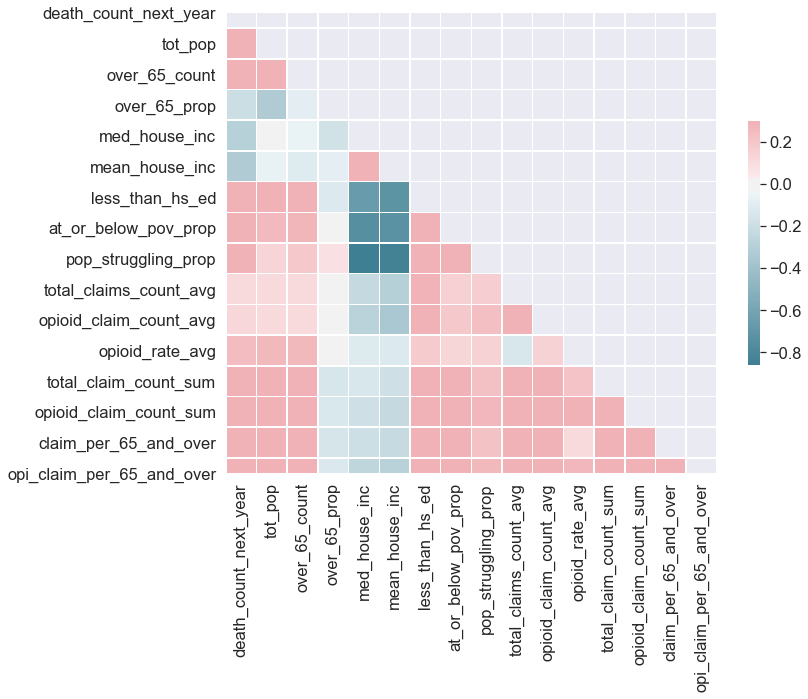

In [23]:
opi_death_rate_corr = acs_death_and_opi_pres.drop(['city_death', 'year', 'urb_v_rur', 'town_status'], axis=1).corr(method="spearman")
mask = np.zeros_like(opi_death_rate_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(opi_death_rate_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [24]:
opi_death_rate_corr[['death_count_next_year']].sort_values('death_count_next_year', ascending=False)

,death_count_next_year
death_count_next_year,1.000000
tot_pop,0.723126
over_65_count,0.715564
total_claim_count_sum,0.650890
opioid_claim_count_sum,0.641590
less_than_hs_ed,0.463468
at_or_below_pov_prop,0.427273
claim_per_65_and_over,0.418149
opi_claim_per_65_and_over,0.390337
pop_struggling_prop,0.370075


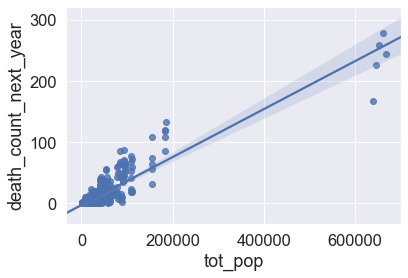

In [29]:
sns.regplot(x='tot_pop', y='death_count_next_year', data=acs_death_and_opi_pres)
plt.show()

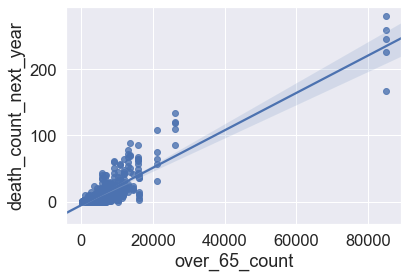

In [28]:
sns.regplot(x='over_65_count', y='death_count_next_year', data=acs_death_and_opi_pres)
plt.show()

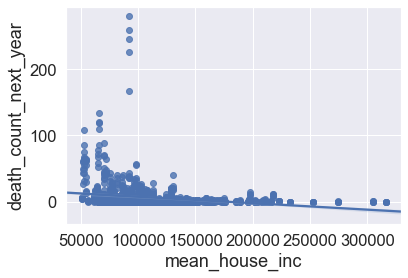

In [26]:
sns.regplot(x='mean_house_inc', y='death_count_next_year', data=acs_death_and_opi_pres)
plt.show()

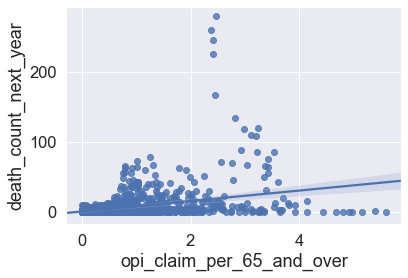

In [27]:
sns.regplot(x='opi_claim_per_65_and_over', y='death_count_next_year', data=acs_death_and_opi_pres)
plt.show()

Of course, these plots aren't very meaningful, because when I will model, the geospatial/time/total population components will also be in the model - that will likely change these relationships

In [70]:
#acs_death_and_opi_pres.to_csv("../../../data/tidy_data/acs_medicare_opioid_stats_death_count_merge.csv", index=False)